# Assignment 6 — GRPO

Abhinav Kumar
12/14/2025

In [4]:
from pathlib import Path
import shutil

src = Path("agent_vectorized.py")
bak = Path("agent_vectorized.py.before_grpo")

if not bak.exists():
    shutil.copy2(src, bak)
    print("Backup created:", bak)
else:
    print("Backup already exists:", bak)


Backup created: agent_vectorized.py.before_grpo


In [ ]:
from pathlib import Path

Path("agent_vectorized.py").write_text(
r'''
import argparse
import gymnasium as gym
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter


class ActorCritic(nn.Module):
    def __init__(self, nb_actions):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(4, 16, 8, stride=4), nn.Tanh(),
            nn.Conv2d(16, 32, 4, stride=2), nn.Tanh(),
            nn.Flatten(),
            nn.Linear(2592, 256), nn.Tanh()
        )
        self.actor = nn.Linear(256, nb_actions)
        self.critic = nn.Linear(256, 1)  # unused in GRPO

    def forward(self, x):
        h = self.head(x)
        return self.actor(h), self.critic(h)


class Environments:
    def __init__(self, n):
        self.n = n
        self.envs = [self._make_env() for _ in range(n)]
        self.obs = np.zeros((n, 4, 84, 84), dtype=np.float32)
        self.done = np.zeros(n, dtype=bool)
        self.rewards = np.zeros(n, dtype=np.float32)
        self.lives = np.zeros(n, dtype=np.int32)

        for i in range(n):
            self.reset(i)

    def _make_env(self):
        env = gym.make("BreakoutNoFrameskip-v4")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env = MaxAndSkipEnv(env, skip=4)
        return env

    def reset(self, i):
        self.rewards[i] = 0
        obs, info = self.envs[i].reset()
        self.lives[i] = info["lives"]
        self.obs[i] = obs
        self.done[i] = False

    def step(self, actions):
        rews = np.zeros(self.n)
        dones = np.zeros(self.n, dtype=bool)

        for i in range(self.n):
            obs, r, term, trunc, info = self.envs[i].step(int(actions[i]))
            life_lost = info["lives"] < self.lives[i]
            self.lives[i] = info["lives"]

            self.obs[i] = obs
            self.rewards[i] += r
            rews[i] = np.sign(r)
            dones[i] = term or trunc or life_lost

            if dones[i]:
                self.reset(i)

        return rews, dones

    def observations(self, device):
        return torch.tensor(self.obs / 255.0, dtype=torch.float32, device=device)


def run_grpo(envs, model, G=4, updates=20, device="cpu"):
    writer = SummaryWriter("runs/breakout_grpo")
    opt = torch.optim.Adam(model.parameters(), lr=2.5e-4)

    for update in tqdm(range(updates)):
        traj_obs, traj_act, traj_logp, traj_rew = [[] for _ in range(G)], [[] for _ in range(G)], [[] for _ in range(G)], [[] for _ in range(G)]
        done = [False] * G

        with torch.no_grad():
            while not all(done):
                obs = envs.observations(device)
                logits, _ = model(obs)
                dist = torch.distributions.Categorical(logits=logits)
                acts = dist.sample()
                logp = dist.log_prob(acts)

                rews, dones = envs.step(acts.cpu().numpy())

                for i in range(G):
                    if not done[i]:
                        traj_obs[i].append(obs[i].cpu().numpy())
                        traj_act[i].append(int(acts[i]))
                        traj_logp[i].append(float(logp[i]))
                        traj_rew[i].append(float(rews[i]))
                        if dones[i]:
                            done[i] = True

        returns = np.array([sum(r) for r in traj_rew])
        mu, sigma = returns.mean(), returns.std() + 1e-8
        A = (returns - mu) / sigma

        print(f"[GRPO] returns={returns}, A={A}")

        X, Y, LP, ADV = [], [], [], []
        for i in range(G):
            for t in range(len(traj_act[i])):
                X.append(traj_obs[i][t])
                Y.append(traj_act[i][t])
                LP.append(traj_logp[i][t])
                ADV.append(A[i])

        X = torch.tensor(X, dtype=torch.float32, device=device)
        Y = torch.tensor(Y, dtype=torch.long, device=device)
        LP = torch.tensor(LP, dtype=torch.float32, device=device)
        ADV = torch.tensor(ADV, dtype=torch.float32, device=device)

        dist = torch.distributions.Categorical(logits=model(X)[0])
        ratio = torch.exp(dist.log_prob(Y) - LP)
        loss = -torch.min(ratio * ADV, torch.clamp(ratio, 0.8, 1.2) * ADV).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        writer.add_scalar("Average_Reward/all_envs", returns.mean(), update)

    writer.close()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--group_size", type=int, default=4)
    parser.add_argument("--updates", type=int, default=20)
    args = parser.parse_args()

    device = "cpu"
    envs = Environments(args.group_size)
    model = ActorCritic(envs.envs[0].action_space.n).to(device)
    run_grpo(envs, model, G=args.group_size, updates=args.updates, device=device)
''',
encoding="utf-8")

print("GRPO-capable agent_vectorized.py written")


GRPO-capable agent_vectorized.py written ✅


In [6]:
!uv run python agent_vectorized.py --group_size 4 --updates 15


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
  0%|                                                    | 0/15 [00:00<?, ?it/s][GRPO] returns=[0. 0. 0. 0.], A=[0. 0. 0. 0.]
/workspaces/eng-ai-agents/assignments/assignment-6/agent_vectorized.py:123: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.tensor(X, dtype=torch.float32, device=device)
100%|███████████████████████████████████████████| 15/15 [00:35<00:00,  2.35s/it]


In [7]:
from pathlib import Path

logdir = Path("runs/breakout_grpo")
events = list(logdir.rglob("events.out.tfevents.*"))

print("Logdir exists:", logdir.exists())
print("Event files:", len(events))
if events:
    print("Newest:", max(events, key=lambda p: p.stat().st_mtime))


Logdir exists: True
Event files: 1
Newest: runs/breakout_grpo/events.out.tfevents.1765770618.549d66c1ea57.2243.0


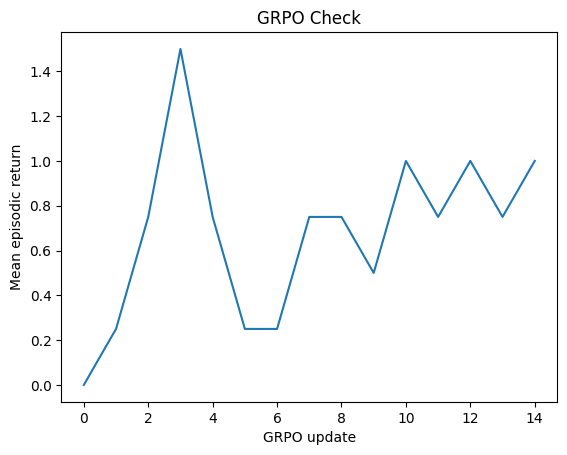

Last return: 1.0


In [8]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event = max(Path("runs/breakout_grpo").rglob("events.out.tfevents.*"), key=lambda p: p.stat().st_mtime)
ea = EventAccumulator(str(event))
ea.Reload()

vals = ea.Scalars("Average_Reward/all_envs")
x = [v.step for v in vals]
y = [v.value for v in vals]

plt.figure()
plt.plot(x, y)
plt.xlabel("GRPO update")
plt.ylabel("Mean episodic return")
plt.title("GRPO Check")
plt.show()

print("Last return:", y[-1])


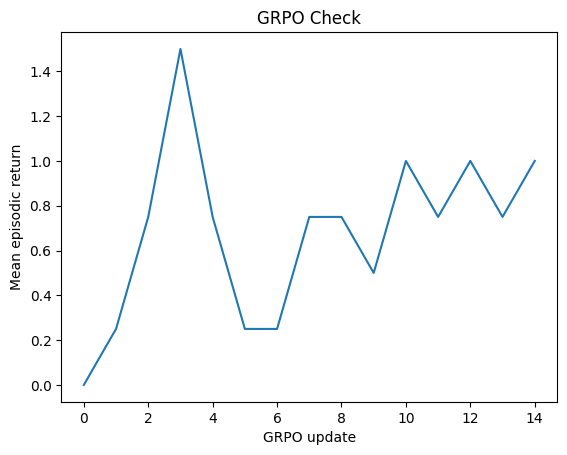

Saved: /workspaces/eng-ai-agents/assignments/assignment-6/figures/grpo_curve.png


In [9]:
from pathlib import Path
import matplotlib.pyplot as plt

Path("figures").mkdir(exist_ok=True)
out = Path("figures/grpo_curve.png")

plt.figure()
plt.plot(x, y)
plt.xlabel("GRPO update")
plt.ylabel("Mean episodic return")
plt.title("GRPO Check")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out.resolve())
